In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import pickle
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import os

2025-02-13 23:49:58.826360: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-13 23:49:58.835171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739470798.845917   25393 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739470798.849416   25393 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-13 23:49:58.860586: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Check if GPU is available

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Importing the data
both the data sets are available in `/data` folder

In [ ]:
dataset_path = "../data/CyberTrollIEEE.csv"
dataset_path2 = "../data/CyberTrollIEEE.csv"
main_data_path = dataset_path + dataset_path2
df = pd.read_csv(dataset_path)

checking the concatenated datasets

In [4]:
df.head()

,content,annotation
0,Get fucking real dude.,1
1,She is as dirty as they come and that crook ...,1
2,why did you fuck it up. I could do it all day...,1
3,Dude they dont finish enclosing the fucking s...,1
4,WTF are you talking about Men? No men thats n...,1


In [5]:
df.isnull().sum()

content       0
annotation    0
dtype: int64

# Visualizing the dataset
heat map of the datasets

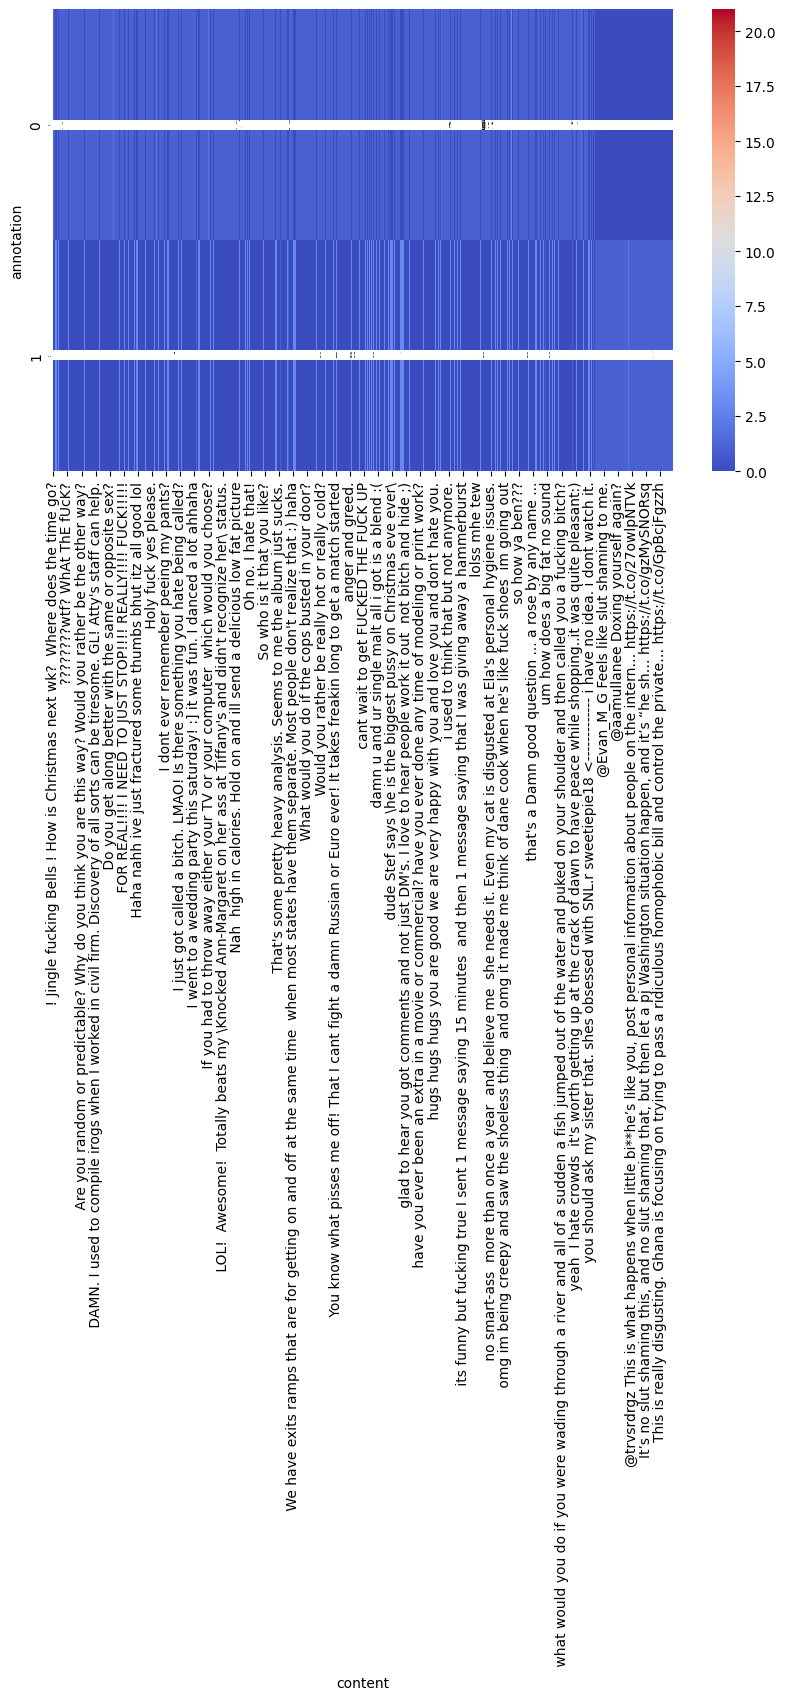

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure the DataFrame has numerical values for heatmap
df_pivot = df.pivot_table(index="annotation", columns="content", aggfunc="size", fill_value=0)

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_pivot, cmap="coolwarm", annot=True)

# Show plot
plt.show()


Countplot of the datasets

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x="annotation", data=df, palette="viridis")

plt.title("Count of Annotations")
plt.xlabel("Annotation")
plt.ylabel("Count")
plt.show()

Histplot of the datasets

In [ ]:
# Calculate text length
df['text_length'] = df['content'].astype(str).apply(len)

# Histplot for text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True, color='skyblue')

plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

Imshow of the database

In [ ]:
# Pivot the DataFrame for imshow visualization
df_pivot = df.pivot_table(index="annotation", columns="content", aggfunc="size", fill_value=0)

# Imshow visualization
plt.figure(figsize=(12, 8))
plt.imshow(df_pivot, cmap="coolwarm", aspect="auto")

plt.title("Imshow of Annotation vs Content")
plt.xlabel("Content")
plt.ylabel("Annotation")
plt.colorbar(label="Count")
plt.show()


check for null values

In [7]:
df.isnull().sum()

content       0
annotation    0
dtype: int64

In [8]:
df.dropna(inplace=True) 

# Model training
Split into training and testing sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['content'], df['annotation'], test_size=0.2, random_state=42)

Save preprocessed data

In [ ]:
preprocessed_data = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}
pickle.dump(preprocessed_data, open("../models/preprocessed_data.pkl", "wb"))

print("Data Preprocessing Completed.")

Data Preprocessing Completed.


TF-IDF Vectorization

In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

Check for existing models before training

In [ ]:
if not os.path.exists("../models/random_forest_model.pkl"):
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_tfidf, y_train)
    pickle.dump(rf_model, open("../models/random_forest_model.pkl", "wb"))
    print("RandomForest Model Trained and Saved.")
else:
    print("RandomForest Model already exists. Skipping training.")

RandomForest Model already exists. Skipping training.


Train and save SVC model

In [ ]:
if not os.path.exists("../models/svc_model.pkl"):
    svc_model = SVC(kernel='linear', probability=True)
    svc_model.fit(X_train_tfidf, y_train)
    pickle.dump(svc_model, open("../models/svc_model.pkl", "wb"))
    print("SVC Model Trained and Saved.")
else:
    print("SVC Model already exists. Skipping training.")

SVC Model already exists. Skipping training.


Tokenizer for BERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [15]:
class CyberbullyDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts.iloc[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }

Prepare BERT datasets

In [ ]:
train_dataset = CyberbullyDataset(X_train, y_train, tokenizer)
test_dataset = CyberbullyDataset(X_test, y_test, tokenizer)

In [ ]:
if not os.path.exists("../models/bert_model.pkl"):
    model = BertForSequenceClassification.from_pretrained("../models/bert-base-uncased", num_labels=2).to(device)
    training_args = TrainingArguments(
        output_dir="../models/results",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir="../models/logs",
        logging_steps=10,
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset
    )
    trainer.train()
    model.save_pretrained("../models/bert_model")
    tokenizer.save_pretrained("../models/bert_model")
    pickle.dump(model, open("../models/bert_model.pkl", "wb"))
    print("BERT Model Trained and Saved.")
else:
    print("BERT Model already exists. Skipping training.")

BERT Model already exists. Skipping training.


Load suspicious words

In [ ]:
sus_words_path = "../data/sus_words.csv"
sus_words = set()
if os.path.exists(sus_words_path):
    sus_df = pd.read_csv(sus_words_path)
    sus_words = set(sus_df['sus_words'].dropna().str.lower())
    print("Suspicious words loaded.")
else:
    print("Suspicious words file not found.")

Suspicious words loaded.


# Manual testing queries

In [ ]:
def test_model(model_path, vectorizer_path, queries):
    flagged_queries = []
    predictions = []
    
    for query in queries:
        words = set(query.lower().split())
        if words & sus_words:
            predictions.append(1)  # Directly classify as bullying
            flagged_queries.append(query)
        else:
            model = pickle.load(open(model_path, "rb"))
            vectorizer = pickle.load(open(vectorizer_path, "rb"))
            queries_tfidf = vectorizer.transform([query]).toarray()
            if (model.predict(queries_tfidf)[0] == 0 ):
                predictions.append(0)
    
    return predictions, flagged_queries

# Sample queries
manual_queries = [
    "You're so dumb, I can't believe you even exist.",
    "Have a great day ahead!",
    "Nobody likes you, just disappear already.",
    "I think your perspective is interesting, let's discuss more!",
    "This is the worst thing I've ever seen, you suck.",
    "mf",
    "you are a muslim what a shame",
]

Save the TF-IDF vectorizer

In [ ]:

if not os.path.exists("../models/tfidf_vectorizer.pkl"):
    pickle.dump(tfidf, open("../models/tfidf_vectorizer.pkl", "wb"))
    print("TF-IDF Vectorizer Saved.")
else:
    print("TF-IDF Vectorizer already exists.")

TF-IDF Vectorizer already exists.


Load and test the RandomForest model

In [ ]:
rf_predictions, rf_flagged = test_model("../models/random_forest_model.pkl", "../models/tfidf_vectorizer.pkl", manual_queries)
print("RandomForest Predictions:", rf_predictions)
print("Flagged Queries (Suspicious Words):", rf_flagged)

RandomForest Predictions: [0, 0, 0, 0, 0, 1, 0]
Flagged Queries (Suspicious Words): ['mf']


Load and test the SVC model

In [ ]:
svc_predictions = test_model("../models/svc_model.pkl", "../models/tfidf_vectorizer.pkl", manual_queries)
print("SVC Predictions:", svc_predictions)

SVC Predictions: ([0, 0, 0, 0, 0, 1, 0], ['mf'])


# Fine Tuning
by using cudf

In [ ]:
import cudf

# Load TF-IDF vectorized data
vectorizer = pickle.load(open("../models/tfidf_vectorizer.pkl", "rb"))
X_train_tfidf = vectorizer.transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

# Convert Pandas DataFrame to cuDF (GPU DataFrame)
X_train_gpu = cudf.DataFrame(X_train_tfidf)
y_train_gpu = cudf.Series(y_train)


In [ ]:
from cuml.ensemble import RandomForestClassifier as cuRF

# Initialize GPU-accelerated RandomForest
rf_model_gpu = cuRF(n_estimators=100, max_depth=20, random_state=42)

# Train on GPU
rf_model_gpu.fit(X_train_gpu, y_train_gpu)

# Save trained model
pickle.dump(rf_model_gpu, open("../models/random_forest_model.pkl", "wb"))
print("GPU-Accelerated RandomForest Model Trained and Saved.")


/home/manish/all_lib/aiml/lib/python3.12/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


GPU-Accelerated RandomForest Model Trained and Saved.


/home/manish/all_lib/aiml/lib/python3.12/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


In [ ]:
from cuml.svm import SVC as cuSVC
import cudf

# Initialize GPU-accelerated SVC
# svc_model_gpu = cuSVC(kernel="rbf", C=1.0, probability=True)
svc_model_gpu = cuSVC(kernel="rbf", C=1.0)


# Train on GPU
svc_model_gpu.fit(X_train_gpu, y_train_gpu)

# Save trained model
pickle.dump(svc_model_gpu, open("../models/svc_model.pkl", "wb"))
print("GPU-Accelerated SVC Model Trained and Saved.")


GPU-Accelerated SVC Model Trained and Saved.


In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluate RandomForest
rf_predictions = rf_model_gpu.predict(X_test_tfidf)
print("\n🔹 RandomForest Results 🔹")
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("Classification Report:\n", classification_report(y_test, rf_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_predictions))

# Save trained RandomForest model
# pickle.dump(rf_model, open("random_forest_model.pkl", "wb"))
print("✅ RandomForest Model Saved.")

# Evaluate SVC
svc_predictions = svc_model_gpu.predict(X_test_tfidf)
print("\n🔹 SVC Results 🔹")
print("Accuracy:", accuracy_score(y_test, svc_predictions))
print("Classification Report:\n", classification_report(y_test, svc_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, svc_predictions))

# Save trained SVC model
# pickle.dump(svc_model, open("svc_model.pkl", "wb"))
print("✅ SVC Model Saved.")



🔹 RandomForest Results 🔹
Accuracy: 0.7030932490404155
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.96      0.78      2445
           1       0.89      0.39      0.54      1984

    accuracy                           0.70      4429
   macro avg       0.77      0.67      0.66      4429
weighted avg       0.76      0.70      0.67      4429

Confusion Matrix:
 [[2347   98]
 [1217  767]]
✅ RandomForest Model Saved.

🔹 SVC Results 🔹
Accuracy: 0.9092345902009483
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      2445
           1       0.90      0.90      0.90      1984

    accuracy                           0.91      4429
   macro avg       0.91      0.91      0.91      4429
weighted avg       0.91      0.91      0.91      4429

Confusion Matrix:
 [[2239  206]
 [ 196 1788]]
✅ SVC Model Saved.


Load the trained SVC model and TF-IDF vectorizer

In [ ]:
svc_model = pickle.load(open("../models/svc_model.pkl", "rb"))
vectorizer = pickle.load(open("../models/tfidf_vectorizer.pkl", "rb"))

# Function to test a single input
def test_input(text):
    words = set(text.lower().split())
    if words & sus_words:
        print("🚨 Detected as Cyberbullying (Suspicious Words Match)")
        return 1  # Directly classify as bullying
    
    # Transform input using TF-IDF vectorizer
    text_tfidf = vectorizer.transform([text]).toarray()
    
    # Predict using the trained model
    prediction = svc_model.predict(text_tfidf)[0]
    
    if prediction == 1:
        print("🚨 Detected as Cyberbullying")
    else:
        print("✅ Safe Message")
    
    return prediction

# Manual test inputs
test_sentences = [
    "You're an idiot, nobody likes you.",  # Should be bullying (1)
    "I hope you have an amazing day!",  # Should be not bullying (0)
    "You're such a loser, get lost.",  # Should be bullying (1)
    "That was a great game, well played!",  # Should be not bullying (0)
    "This is the dumbest thing I've ever seen.",  # Should be bullying (1)
]

# Run tests
for sentence in test_sentences:
    print(f"📝 Testing: \"{sentence}\"")
    test_input(sentence)
    print("-" * 40)


📝 Testing: "You're an idiot, nobody likes you."
✅ Safe Message
----------------------------------------
📝 Testing: "I hope you have an amazing day!"
✅ Safe Message
----------------------------------------
📝 Testing: "You're such a loser, get lost."
🚨 Detected as Cyberbullying
----------------------------------------
📝 Testing: "That was a great game, well played!"
✅ Safe Message
----------------------------------------
📝 Testing: "This is the dumbest thing I've ever seen."
✅ Safe Message
----------------------------------------
